# Ensemble learning

In [0]:
%load_ext tensorboard
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [6]:
%%time
path = './model/'
inception = tf.keras.models.load_model(path + 'inceptionV3-regularized-04-0.83.hdf5')
vgg = tf.keras.models.load_model(path + 'vgg19-regularized-18-0.78.hdf5')
mobilenet = tf.keras.models.load_model(path + 'mobilenet-regularized-05-0.80.hdf5')

CPU times: user 9.45 s, sys: 879 ms, total: 10.3 s
Wall time: 49.3 s


In [0]:
models = [inception, vgg, mobilenet]

for i in range(3):
  model = models[i]
  for layer in model.layers:
    layer.trainable = False
    layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

In [0]:
model_inputs = [model.input for model in models]
model_outputs = [model.layers[-2].output for model in models]

In [0]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32, 64, 128]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/final_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [0]:
BATCH_SIZE = 32

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rescale=1.0/255.0,
    horizontal_flip=True, 
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=30
)

In [0]:
def generate_generator_multiple(generator,dir1, batch_size):
    
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = (300, 300),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          shuffle=True, 
                                          seed=7)
    
    genX2 = generator.flow_from_directory(dir1,
                                          target_size = (300, 300),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          shuffle=True, 
                                          seed=7)
    
    genX3 = generator.flow_from_directory(dir1,
                                          target_size = (224, 224),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          shuffle=True, 
                                          seed=7)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        X3i = genX3.next()
        yield [X1i[0], X2i[0], X3i[0]], X2i[1] 

In [0]:
train_generator = generate_generator_multiple(datagen, './training/', 32)
val_generator = generate_generator_multiple(datagen, './validation/', 32)

In [0]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        
        merge = tf.keras.layers.concatenate(model_outputs)
        hidden = tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu')(merge)
        hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
        output = tf.keras.layers.Dense(11, activation='softmax')(hidden)
        model = tf.keras.models.Model(inputs=model_inputs, outputs=output)
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['acc']
        )
        
        model.fit(
            x=train_generator, 
            epochs=1,
            steps_per_epoch=100,
            batch_size=32
        )
        
        _, accuracy = model.evaluate(val_generator, steps=40, batch_size=32)
        
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [21]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    
    hparams = {
        HP_NUM_UNITS: num_units
    }
        
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/' + run_name, hparams)
    session_num += 1

--- Starting trial: run-0
{'num_units': 32}
100/100 [==============================] - 237s 2s/step - loss: 1.6877 - acc: 0.7634
Found 3430 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
40/40 [==============================] - 96s 2s/step - loss: 1.2889 - acc: 0.8461
--- Starting trial: run-1
{'num_units': 64}
40/40 [==============================] - 98s 2s/step - loss: 1.3100 - acc: 0.8602
--- Starting trial: run-2
{'num_units': 128}
40/40 [==============================] - 94s 2s/step - loss: 1.2781 - acc: 0.8612


### Results:

It appears that 128 number of units works really best.

In [0]:
merge = tf.keras.layers.concatenate(model_outputs)
hidden = tf.keras.layers.Dense(128, activation='relu')(merge)
hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
output = tf.keras.layers.Dense(11, activation='softmax')(hidden)
model = tf.keras.models.Model(inputs=model_inputs, outputs=output)

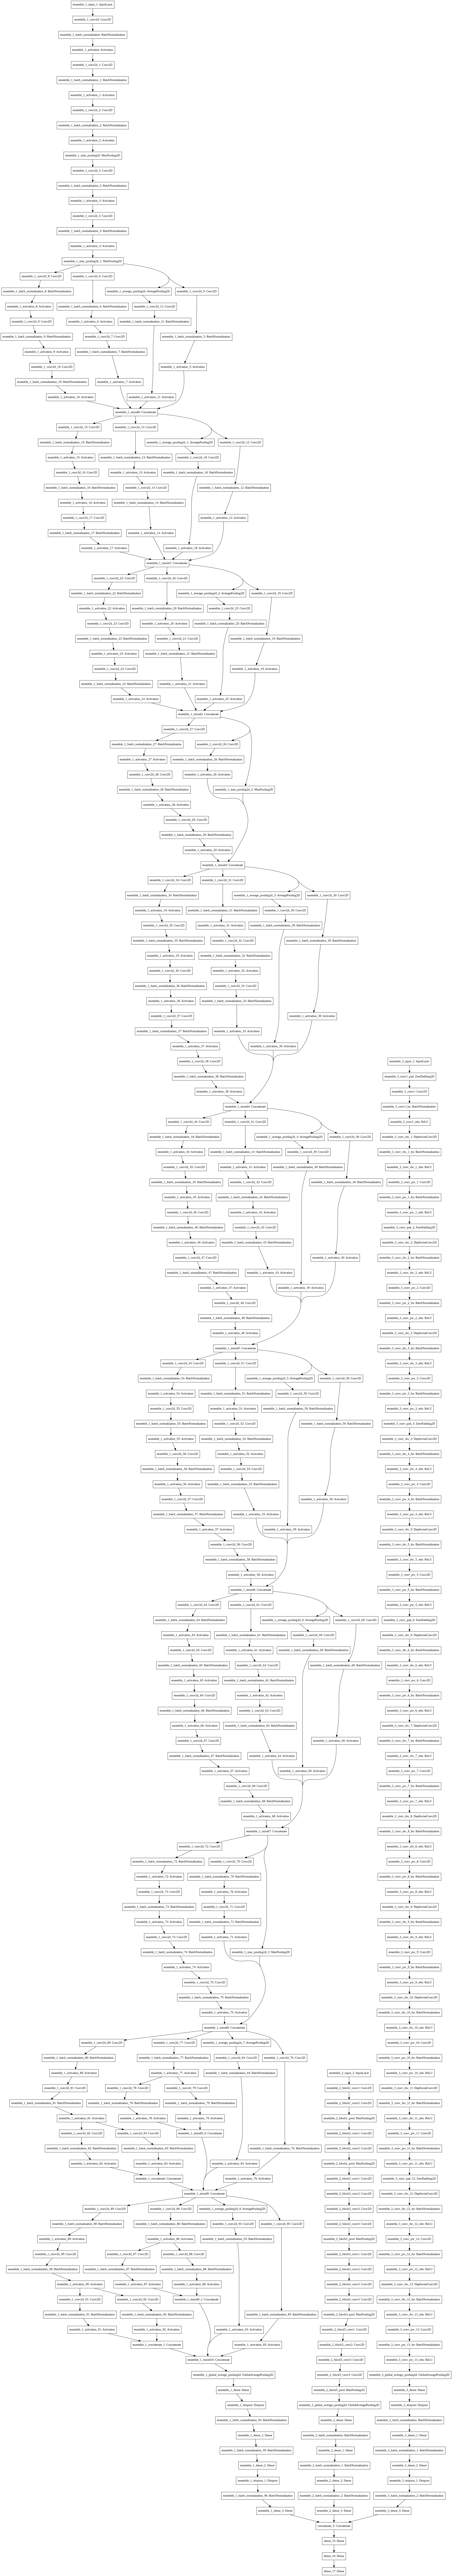

In [25]:
tf.keras.utils.plot_model(model)

In [0]:
filepath="./models/ensemble-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=2)

In [0]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [28]:
%%time
model.fit(
    x=train_generator,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch=300,
    validation_steps=100,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 1.1450 - acc: 0.9034
Epoch 00001: val_acc improved from -inf to 0.87177, saving model to ./models/ensemble-01-0.87.hdf5
300/300 [==============================] - 964s 3s/step - loss: 1.1450 - acc: 0.9034 - val_loss: 1.2563 - val_acc: 0.8718
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 1.0328 - acc: 0.9296
Epoch 00002: val_acc did not improve from 0.87177
300/300 [==============================] - 955s 3s/step - loss: 1.0328 - acc: 0.9296 - val_loss: 1.2840 - val_acc: 0.8614
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 1.0084 - acc: 0.9391
Epoch 00003: val_acc did not improve from 0.87177
300/300 [==============================] - 966s 3s/step - loss: 1.0084 - acc: 0.9391 - val_loss: 1.2920 - val_acc: 0.8697
CPU times: user 51min 21s, sys: 1min 22s, total: 52min 43s
Wall time: 48min 17s


In [29]:
%%time
best_model = tf.keras.models.load_model('./models/ensemble-01-0.87.hdf5')

CPU times: user 8.56 s, sys: 293 ms, total: 8.85 s
Wall time: 8.76 s


In [0]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rescale=1.0/255.0
)

In [0]:
test_generator = generate_generator_multiple(test_datagen, './evaluation/', BATCH_SIZE)

In [36]:
best_model.evaluate(test_generator, batch_size=BATCH_SIZE, steps=50)

50/50 [==============================] - 53s 1s/step - loss: 1.1531 - acc: 0.9050


[1.1530710458755493, 0.9049999713897705]

### Results:

Accuracy acheived by inceptionV3:- 0.853<br>
Accuracy acheived by ensemble of vgg19, mobilenet and inceptionV3:- 0.905<br>

Clearly an improvement of 0.052 => 5.2% by ensemble learning.